# Introduction

Walk through the Azure Automatic Machine Learning model training using local machine. 
- Use Dataprep to select columns and infer data type
- Use AutoML and understand prediction performance
- Validate on Out-of-Time sample to benchmark previous model work

### Imports
Import libraries and write settings here.

In [1]:
# Data manipulation
import pandas as pd
import numpy as np
import os
import importlib

# Options for pandas
pd.options.display.max_columns = 2000
pd.options.display.max_rows = 30

# Visualizations
import matplotlib.pyplot as plt

In [2]:
# Import Azure libraries
import azureml.dataprep as dprep

C:\Users\cwei\AppData\Local\Continuum\anaconda3\envs\myenv\lib\site-packages\requests\__init__.py:91: RequestsDependencyWarning: urllib3 (1.25.2) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


# Dataprep

### Load & Clean Data

Here we are using the Conquest Model dataset which a RandomForest Model was fitted with OOT AUC at 0.7821 

In [3]:
train = dprep.read_csv('data/exp_all_201612_nonsd.csv')

In [4]:
# define the columns needed
useful_columns = ['sales_nonsd','auto_in_the_market_used_0_5_vehicle','apm_used_0_5_suv_domestic_standard',
                  'apm_used_0_5_pickup','apm_used_0_5_sports_car_domestic','apm_used_0_5_suv_domestic_premium',
                  'apm_used_0_5_luxury_car_domestic','act_int_hunting_enthusiasts','buyer_non_prestige_makeup_brand_user',
                  'apm_used_0_5_mini_van_domestic','auto_in_the_market_new','consumerview_profitability_score',
                  'buyer_presence_of_automobile','apm_used_6_10_pickup','apm_used_0_5_small_car_standard',
                  'person_1_marital_status']

In [7]:
train2 = (train
    .keep_columns(columns=useful_columns))

### Inferred Data Type

In [8]:
type_infer = train2.builders.set_column_types()
type_infer.learn()
type_infer

Column types conversion candidates:
'apm_used_0_5_sports_car_domestic': [FieldType.INTEGER],
'apm_used_0_5_suv_domestic_standard': [FieldType.INTEGER],
'auto_in_the_market_new': [FieldType.INTEGER],
'buyer_presence_of_automobile': [FieldType.INTEGER],
'sales_nonsd': [FieldType.DECIMAL],
'apm_used_0_5_luxury_car_domestic': [FieldType.INTEGER],
'apm_used_0_5_mini_van_domestic': [FieldType.INTEGER],
'apm_used_0_5_pickup': [FieldType.INTEGER],
'act_int_hunting_enthusiasts': [FieldType.INTEGER],
'consumerview_profitability_score': [FieldType.INTEGER],
'person_1_marital_status': [FieldType.STRING],
'apm_used_0_5_small_car_standard': [FieldType.INTEGER],
'apm_used_0_5_suv_domestic_premium': [FieldType.INTEGER],
'apm_used_6_10_pickup': [FieldType.INTEGER],
'auto_in_the_market_used_0_5_vehicle': [FieldType.INTEGER],
'buyer_non_prestige_makeup_brand_user': [FieldType.INTEGER]

In [9]:
train2 = type_infer.to_dataflow()

In [10]:
train2.head(5)

,person_1_marital_status,apm_used_0_5_small_car_standard,apm_used_0_5_sports_car_domestic,apm_used_0_5_luxury_car_domestic,apm_used_0_5_suv_domestic_standard,apm_used_0_5_suv_domestic_premium,apm_used_0_5_mini_van_domestic,apm_used_0_5_pickup,apm_used_6_10_pickup,auto_in_the_market_new,auto_in_the_market_used_0_5_vehicle,act_int_hunting_enthusiasts,buyer_presence_of_automobile,buyer_non_prestige_makeup_brand_user,consumerview_profitability_score,sales_nonsd
0,1M,4,3,3,4,4,6,1,3,2,2,37,65,84,3,0.0
1,5U,8,6,4,8,8,9,8,8,2,8,44,69,14,3,0.0
2,5M,8,9,9,8,8,9,8,9,9,9,57,79,30,8,0.0
3,1M,8,8,6,8,8,8,7,4,6,6,18,26,64,3,0.0
4,5S,7,9,8,7,7,9,9,9,3,8,82,85,9,6,0.0


# AutoML

In [11]:
# import libraries
import azureml.core
import pandas as pd
from azureml.core.workspace import Workspace
import logging
import os

In [12]:
# configure workspace
ws = Workspace.from_config()
# choose a name for the run history container in the workspace
experiment_name = 'automated-ml-regression'
# project folder
project_folder = './automated-ml-regression'

output = {}
output['SDK version'] = azureml.core.VERSION
output['Subscription ID'] = ws.subscription_id
output['Workspace'] = ws.name
output['Resource Group'] = ws.resource_group
output['Location'] = ws.location
output['Project Directory'] = project_folder
pd.set_option('display.max_colwidth', -1)
outputDf = pd.DataFrame(data = output, index = [''])
outputDf.T

,
SDK version,1.0.33
Subscription ID,12434d83-af58-402b-926d-5e7af974d1ee
Workspace,myworkspace
Resource Group,myresourcegroup
Location,eastus2
Project Directory,./automated-ml-regression


In [13]:
dflow_X = train2.drop_columns('sales_nonsd')
dflow_y = train2.keep_columns('sales_nonsd')

### Split Data to Train and Test

In [14]:
from sklearn.model_selection import train_test_split

x_df = dflow_X.to_pandas_dataframe()
y_df = dflow_y.to_pandas_dataframe()

x_train, x_test, y_train, y_test = train_test_split(x_df, y_df, test_size=0.2, random_state=223)
# flatten y_train to 1d array
y_train.values.flatten()

array([0., 0., 0., ..., 1., 1., 0.])

## Automatically Training

### Define Settings for Autogeneration and Tuning

In [15]:
automl_settings = {
    "iteration_timeout_minutes" : 10,
    "iterations" : 3,
    "primary_metric" : 'AUC_weighted',
    "preprocess" : True,
    "verbosity" : logging.INFO,
    "n_cross_validations": 5,
    "max_cores_per_iteration": 2,
    "max_concurrent_iterations": 1,
}

In [16]:
# any model specifically want to whitelist and focus on for training
ALL = ['LogisticRegression', 'SGD', 'MultinomialNaiveBayes', 'BernoulliNaiveBayes', 'SVM', 'LinearSVM',
       'KNN', 'DecisionTree', 'RandomForest', 'ExtremeRandomTrees', 'LightGBM', 'XGBoostClassifier',
       'GradientBoosting', 'TensorFlowDNN', 'TensorFlowLinearClassifier']
TRY = ['XGBoostClassifier']

In [17]:
from azureml.train.automl import AutoMLConfig

# local compute 
automated_ml_config = AutoMLConfig(task = 'classification',
                             debug_log = 'automated_ml_errors.log',
                             path = project_folder,
                             X = x_train.values,
                             y = y_train.values.flatten(),
#                              auto_blacklist=False,
#                              blacklist_models=[],
#                              enable_early_stopping=True,
#                              enable_tf=True,
                             whitelist_models=TRY,
#                              enable_onnx_compatible_models=True,
#                              iterations=5,
#                              n_cross_validations=2,
#                              verbosity=100,
                             **automl_settings)

### Train Automatic Models

In [18]:
from azureml.core.experiment import Experiment
experiment=Experiment(ws, experiment_name)
local_run = experiment.submit(automated_ml_config, show_output=True)

Running on local machine
Parent Run ID: AutoML_8dbbb6ef-dc56-4fc3-ab3f-b1631e1e48cf
Current status: DatasetEvaluation. Gathering dataset statistics.
Current status: FeaturesGeneration. Generating features for the dataset.
Current status: DatasetFeaturization. Featurizing the dataset.
Current status: DatasetCrossValidationSplit. Generating individually featurized CV splits.
Current status: DatasetFeaturization. Featurizing the dataset.
Current status: DatasetFeaturization. Featurizing the dataset.
Current status: DatasetFeaturization. Featurizing the dataset.
Current status: DatasetFeaturization. Featurizing the dataset.
Current status: DatasetFeaturization. Featurizing the dataset.
Current status: DatasetFeaturization. Featurizing the dataset.
Current status: DatasetFeaturization. Featurizing the dataset.
Current status: DatasetFeaturization. Featurizing the dataset.
Current status: DatasetFeaturization. Featurizing the dataset.
Current status: DatasetFeaturization. Featurizing the dat

# Out of Time Sample Validation

In [19]:
oot = dprep.read_csv('data2/exp_all_201704_nonsd.csv')

In [20]:
oot2 = (oot
    .keep_columns(columns=useful_columns))

In [21]:
type_infer = oot2.builders.set_column_types()
type_infer.learn()
type_infer

Column types conversion candidates:
'person_1_marital_status': [FieldType.STRING],
'apm_used_0_5_sports_car_domestic': [FieldType.INTEGER],
'apm_used_0_5_mini_van_domestic': [FieldType.INTEGER],
'apm_used_6_10_pickup': [FieldType.INTEGER],
'act_int_hunting_enthusiasts': [FieldType.INTEGER],
'consumerview_profitability_score': [FieldType.INTEGER],
'apm_used_0_5_luxury_car_domestic': [FieldType.INTEGER],
'apm_used_0_5_suv_domestic_premium': [FieldType.INTEGER],
'apm_used_0_5_pickup': [FieldType.INTEGER],
'auto_in_the_market_used_0_5_vehicle': [FieldType.INTEGER],
'buyer_non_prestige_makeup_brand_user': [FieldType.INTEGER],
'apm_used_0_5_small_car_standard': [FieldType.INTEGER],
'apm_used_0_5_suv_domestic_standard': [FieldType.INTEGER],
'auto_in_the_market_new': [FieldType.INTEGER],
'buyer_presence_of_automobile': [FieldType.INTEGER],
'sales_nonsd': [FieldType.DECIMAL]

In [22]:
oot2 = type_infer.to_dataflow()

In [23]:
oot2.head(5)

,person_1_marital_status,apm_used_0_5_small_car_standard,apm_used_0_5_sports_car_domestic,apm_used_0_5_luxury_car_domestic,apm_used_0_5_suv_domestic_standard,apm_used_0_5_suv_domestic_premium,apm_used_0_5_mini_van_domestic,apm_used_0_5_pickup,apm_used_6_10_pickup,auto_in_the_market_new,auto_in_the_market_used_0_5_vehicle,act_int_hunting_enthusiasts,buyer_presence_of_automobile,buyer_non_prestige_makeup_brand_user,consumerview_profitability_score,sales_nonsd
0,5U,8,9,6,9,9,9,9,9,2,8,76,99,99,5,0.00
1,5S,9,9,7,9,9,8,9,9,3,8,91,99,23,8,0.00
2,5M,4,1,1,1,1,4,1,1,2,1,18,40,52,2,0.00
3,5M,9,9,8,7,7,9,9,9,1,8,95,90,1,5,0.00
4,1M,5,5,3,3,3,6,7,7,3,4,15,18,27,5,0.00


In [24]:
dflow_X = oot2.drop_columns('sales_nonsd')
dflow_y = oot2.keep_columns('sales_nonsd')

In [25]:
x_valid = dflow_X.to_pandas_dataframe()
y_valid = dflow_y.to_pandas_dataframe().values.flatten()

In [26]:
best_run, fitted_model = local_run.get_output()
print(best_run)
print(fitted_model)

Run(Experiment: automated-ml-regression,
Id: AutoML_8dbbb6ef-dc56-4fc3-ab3f-b1631e1e48cf_2,
Type: None,
Status: Completed)
Pipeline(memory=None,
     steps=[('datatransformer', DataTransformer(enable_feature_sweeping=None, feature_sweeping_timeout=None,
        is_onnx_compatible=None, logger=None, observer=None, task=None)), ('stackensembleclassifier', StackEnsembleClassifier(base_learners=[('0', Pipeline(memory=None,
     steps=[('standardscale...olver='warn',
          tol=0.0001, verbose=0, warm_start=False),
            training_cv_folds=5))])
Y_transformer(['LabelEncoder', LabelEncoder()])


In [27]:
# generate prediction probability and show results on 10 samples
y_predict = fitted_model.predict_proba(x_valid.values)
y_predict = [i[1] for i in y_predict]
y_predict[:10]

[0.06113428963169904,
 0.05360933275188112,
 0.6190585140486702,
 0.06572059010097338,
 0.2619511607798809,
 0.08130265629002645,
 0.06422660494819021,
 0.3652146737303583,
 0.24014917464056826,
 0.0743624937100273]

(blue)  Best  roc: 0.7664055032466996
(red) random roc: 0.5
1 2.8329055348504486
2 2.723565321224642
3 2.6650296513037555
4 2.603870920702452
5 2.5532596551529307
6 2.5142726900924157
7 2.4599181394515925
8 2.416874305353771
9 2.3730875994341774
10 2.3312658880944745
11 2.2973493369807945
12 2.276126391475602
13 2.249120548114061
14 2.2213576733589235
15 2.197296515237804
16 2.1697198641371034
17 2.1500651811284985
18 2.1300173097155275
19 2.1103358775003205
20 2.086327242873633
21 2.06570959148034
22 2.0450836925961853
23 2.026899612272861
24 2.0107140673649786
25 1.997943903526106
26 1.9779364285386332
27 1.9594723468799888
28 1.9409662922048656
29 1.9235651375173284
30 1.9066613918475916
31 1.8894053043696966
32 1.874366682917772
33 1.8557213024233001
34 1.8389523183830545
35 1.8246562316282364
36 1.8091755717529328
37 1.792740709813136
38 1.778827510510434
39 1.7618896816463048
40 1.7478695816046586
41 1.7353011139593122
42 1.7191894700147146
43 1.7029410790959432
44 1.687167690279

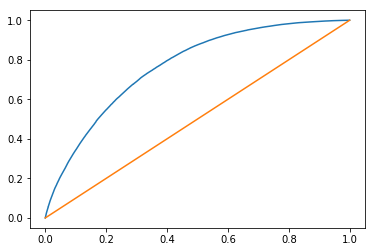

In [28]:
rank_count = 100
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_valid, y_predict)

#plotting roc
print("(blue) ", 'Best', " roc:", metrics.auc(fpr,tpr))
print("(red) random roc: 0.5")
plt.plot(fpr,tpr,
         [0,1],[0,1])

#Lift
deciles = pd.DataFrame({'y' : y_valid,
                        'yhat' : y_predict})

decile_length = deciles.shape[0]//rank_count
overall_rate = deciles['y'].mean()

decile_event_cum = 0
decile_count_cum = 0
for decile_n in range(rank_count):

    decile_event = deciles.\
        sort_values('yhat', ascending= False).\
        reset_index(drop=True).\
        loc[decile_n*decile_length:(decile_n+1)*decile_length,'y'].\
        values.\
        sum()    

    decile_count = deciles.\
        reset_index(drop=True).\
        loc[decile_n*decile_length:(decile_n+1)*decile_length,'y'].\
        count()

    decile_event_cum += decile_event

    decile_count_cum += decile_count

    print(decile_n + 1, decile_event_cum / decile_count_cum / overall_rate)

# Conclusion

Only run on one xgboost model to test the flow and returned AUC at 0.7664. Will see if we can beat previous 0.7821 with more iterations.